In [ ]:
#@title Setup Repository
#@markdown This process may take serveral minutes (about 9 minutes) for the first run..
!git clone https://github.com/P2Oileen/oh-my-face.git

#install cuda10.0
!apt-get update;
!wget https://developer.nvidia.com/compute/cuda/10.0/Prod/local_installers/cuda-repo-ubuntu1604-10-0-local-10.0.130-410.48_1.0-1_amd64 -O cuda-repo-ubuntu1604-10-0-local-10.0.130-410.48_1.0-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-10-0-local-10.0.130-410.48_1.0-1_amd64.deb
!apt-key add /var/cuda-repo-10-0-local/7fa2af80.pub
!apt-get update
!apt-get -y install gcc-7 g++-7
!apt-get -y install cuda 

!export PATH=/usr/local/cuda/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda/lib64\${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}
!export CUDA_HOME=/usr/local/cuda

# check if installed successfully
!/usr/local/cuda/bin/nvcc --version

!pip install tensorflow-gpu==1.15.2
!pip install ftfy regex tqdm gdown
!pip install git+https://github.com/openai/CLIP.git
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%load_ext autoreload
%autoreload 2

In [69]:
#@title Setup Files Downloader
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

download_with_pydrive = True #@param {type:"boolean"}

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive
        current_directory = os.getcwd()
        self.save_dir = os.path.join(os.path.dirname(current_directory), "content/oh-my-face")
        os.makedirs(self.save_dir, exist_ok=True)
        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_name):
        file_dst = f'{self.save_dir}/{file_name}'
        if os.path.exists(file_dst):
            print(f'{file_name} already exists!')
            return
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

# Step 1: Select Data Type
Select which experiment you wish to perform inference on:

'face' refers to human face, while 'cat' refers to cat face.

In [3]:
data_type = 'face' #@param ['face', 'cat']

In [4]:
#@title Download Weights from Google Drive
#@markdown It may take about one minute.
if data_type == 'face':
  downloader.download_file('1efFoGShtZhcd6SCxOPu3AMbKZus478au', 'ffhq.tar.gz')
  downloader.download_file('1bXhWOnwCTTXTz7T7zJ1iXA717tyj-n3U', 'weights-face.tar.gz')
else:
  None
!tar -zxvf oh-my-face/ffhq.tar.gz 
!mv ffhq oh-my-face/src/
!tar -zxvf oh-my-face/weights-face.tar.gz
!mv weights oh-my-face/src/

ffhq/
ffhq/W.npy
ffhq/S
ffhq/S_mean_std
ffhq/fs3.npy
ffhq/ffhq.pkl
weights/
weights/shape_predictor_68_face_landmarks.dat
weights/flownet.pkl
weights/e4e_ffhq_encode.pt


# Step 2: Upload an image with human face / cat face

Please upload to `oh-my-face/input.jpg`.

# Step 3: Edit image 

Aligned image:


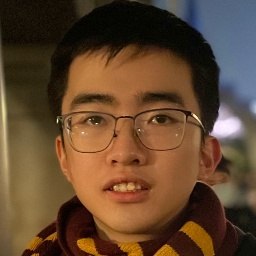

In [80]:
#@title Get latent code via Encoder4Editing
#@markdown If changed input image, please start over from this block.
%reload_ext autoreload
%autoreload 2
os.chdir('/content/oh-my-face/src')
from cog_predict import get_latent_code
import cv2
import torch
from IPython.display import Image

img = cv2.imread('/content/oh-my-face/input.jpg')
latent, img = get_latent_code(img, data_type, '/content/oh-my-face/src/weights')
latent = latent.unsqueeze(0)
cv2.imwrite("../input_aligned.jpg",img)
torch.save(latent,"../tmp_latent.pt")

print("Aligned image:")
Image(filename = "../input_aligned.jpg", width=300, height=300)

# modify manipulation strength (alhpa) and disentangle threshold (beta)

- *Manipulation strength* - positive values correspond to moving along the target direction.
- *Disentanglement threshold* - large value means more disentangled edit, just a few channels will be manipulated so only the target attribute will change (for example, grey hair). Small value means less disentangled edit, a large number of channels will be manipulated, related attributes will also change (such as wrinkle, skin color, glasses).

- In the terminal, for every manipulation, the number of channels being manipulated is printed (the number is controlled by the attribute (neutral, target) and the disentanglement threshold).

- For color transformation, usually 10-20 channels is enough. For large structure change (for example, Hi-top fade), usually 100-200 channels are required.
- For an attribute (neutral, target), if you give a low disentanglement threshold, there are just few channels (<20) being manipulated, and usually it is not enough for performing the desired edit.

(text copied from https://colab.research.google.com/github/orpatashnik/StyleCLIP/blob/main/notebooks/StyleCLIP_global.ipynb)

0.2896
num of channels being manipulated: 4
Edited image:


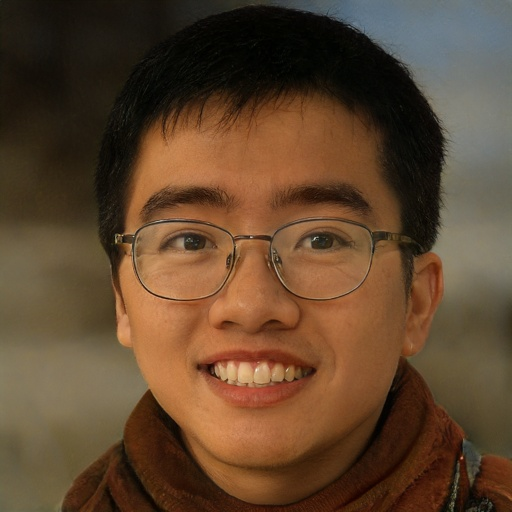

In [83]:
#@title Edit latent code via StyleCLIP
#@markdown This process may take serveral minutes for the first run.

%reload_ext autoreload
%autoreload 2
from global_singleimg_infer import global_transfer
import numpy as np
import torch
import cv2
import sys
os.chdir('/content/oh-my-face/src')
sys.path.append("./global_directions")
sys.path.append("src")

latent = torch.load("../tmp_latent.pt")
neutral = 'face' #@param {type:"string"}
target = 'face with smile' #@param {type:"string"}
beta = 0.19 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 2.4 #@param {type:"slider", min:-10, max:10, step:0.1}

result = global_transfer(latent.cpu().detach().numpy(), neutral = neutral, target = target, beta = beta, alpha = alpha)
cv2.imwrite("../output.jpg",result[:,:,::-1])

print("StyleCLIP Edited image:")
Image(filename = "../output.jpg", width=300, height=300)

Loaded v3.x HD model.
Edited image:


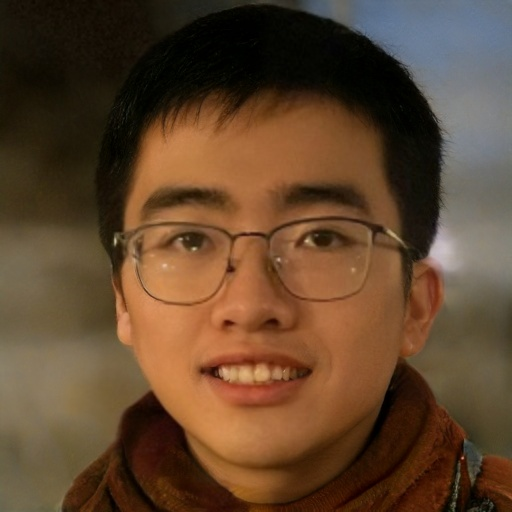

In [85]:
#@title Convert the generated image to be similar with the origin via RIFE
#@markdown Smaller gamma generates a more similar face.
import os
import cv2
import torch
import torchvision.transforms as T
import argparse
from torch.nn import functional as F
import warnings
import time
warnings.filterwarnings("ignore")
os.chdir('/content/oh-my-face/src/rife')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)
if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

img = ['../../output.jpg', '../../input_aligned.jpg']
exp = 1
ratio = 0
rthreshold = 0.02
rmaxcycles = 8
model_dir = '/content/oh-my-face/src/weights'
gamma = 5 #@param {type:"slider", min:1, max:10, step:1}

from train_log.RIFE_HDv3 import Model
model = Model()
model.load_model(model_dir, -1)
print("Loaded v3.x HD model.")
model.eval()
model.device()

img0 = cv2.imread(img[0]).astype('uint8')
img1 = cv2.imread(img[1]).astype('uint8')
img0 = torch.tensor(cv2.resize(img0, (512, 512)),dtype=torch.float32) / 255.
img1 = torch.tensor(cv2.resize(img1, (512, 512)),dtype=torch.float32) / 255.
s0 = img0.std(dim=(0,1))
m0 = img0.mean(dim=(0,1))
s1 = img1.std(dim=(0,1))
m1 = img1.mean(dim=(0,1))
img0 = m1 + (img0 - m0) * s1 / s0
img0 = torch.clamp(img0, 0, 1)
img0 = img0.permute(2, 0, 1)
img1 = img1.permute(2, 0, 1)
img0 = img0.to(device).unsqueeze(0)
img1 = img1.to(device).unsqueeze(0)
n, c, h, w = img0.shape
ph = ((h - 1) // 64 + 1) * 64
pw = ((w - 1) // 64 + 1) * 64
padding = (0, pw - w, 0, ph - h)
img0 = F.pad(img0, padding)
img1 = F.pad(img1, padding)


img_output = model.inference(img0, img1, 0.5, gamma=gamma)

cv2.imwrite('../../output_rife.jpg', (img_output[0] * 255).byte().cpu().numpy().transpose(1, 2, 0)[:h, :w])

print("RIFE Edited image:")
Image(filename = "../../output_rife.jpg", width=300, height=300)
